In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc
import numpy as np
from tensorflow.keras.regularizers import l2

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert to float32 and normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Resize images to 64x64
train_images_resized = tf.image.resize(train_images[..., tf.newaxis], (32, 32))
test_images_resized = tf.image.resize(test_images[..., tf.newaxis], (32, 32))

# Convert to RGB channels by duplicating the single channel
train_images_rgb = tf.concat([train_images_resized] * 3, axis=-1)
test_images_rgb = tf.concat([test_images_resized] * 3, axis=-1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)




Epoch 1/10
844/844 [==============================] - 8s 8ms/step - loss: 0.6262 - accuracy: 0.8186 - val_loss: 0.2118 - val_accuracy: 0.9433
Epoch 2/10
844/844 [==============================] - 7s 9ms/step - loss: 0.2974 - accuracy: 0.9136 - val_loss: 0.1582 - val_accuracy: 0.9568
Epoch 3/10
844/844 [==============================] - 7s 9ms/step - loss: 0.2341 - accuracy: 0.9319 - val_loss: 0.1310 - val_accuracy: 0.9642
Epoch 4/10
844/844 [==============================] - 7s 9ms/step - loss: 0.2020 - accuracy: 0.9406 - val_loss: 0.1128 - val_accuracy: 0.9677
Epoch 5/10
844/844 [==============================] - 7s 8ms/step - loss: 0.1779 - accuracy: 0.9481 - val_loss: 0.1013 - val_accuracy: 0.9712
Epoch 6/10
844/844 [==============================] - 7s 9ms/step - loss: 0.1583 - accuracy: 0.9540 - val_loss: 0.0921 - val_accuracy: 0.9722
Epoch 7/10
844/844 [==============================] - 7s 8ms/step - loss: 0.1443 - accuracy: 0.9579 - val_loss: 0.0872 - val_accuracy: 0.9760
Epoch 

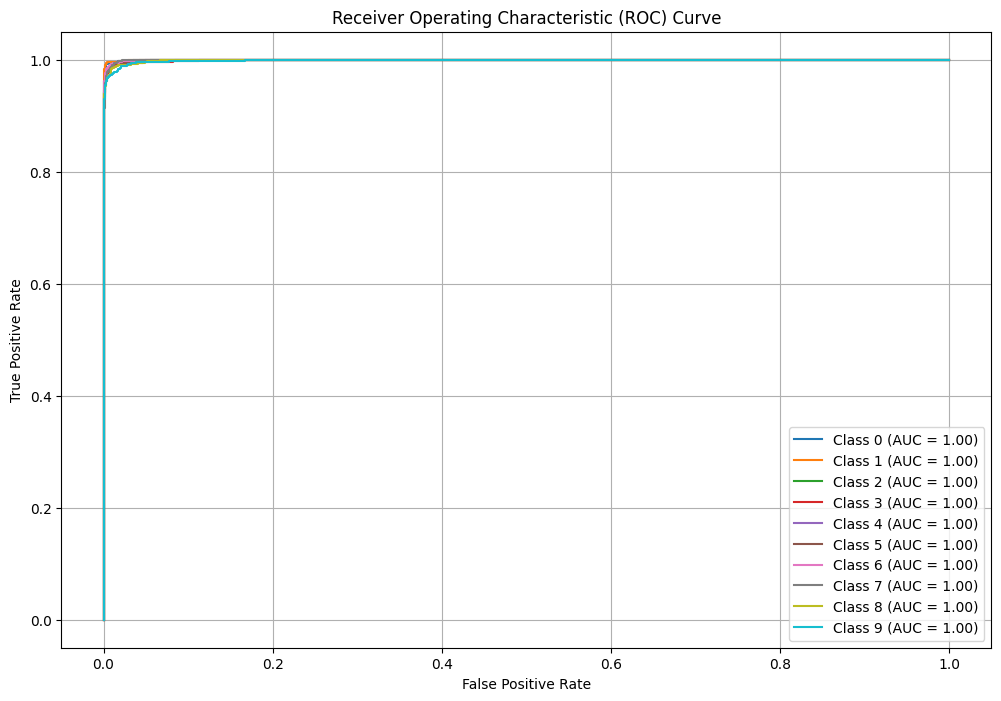

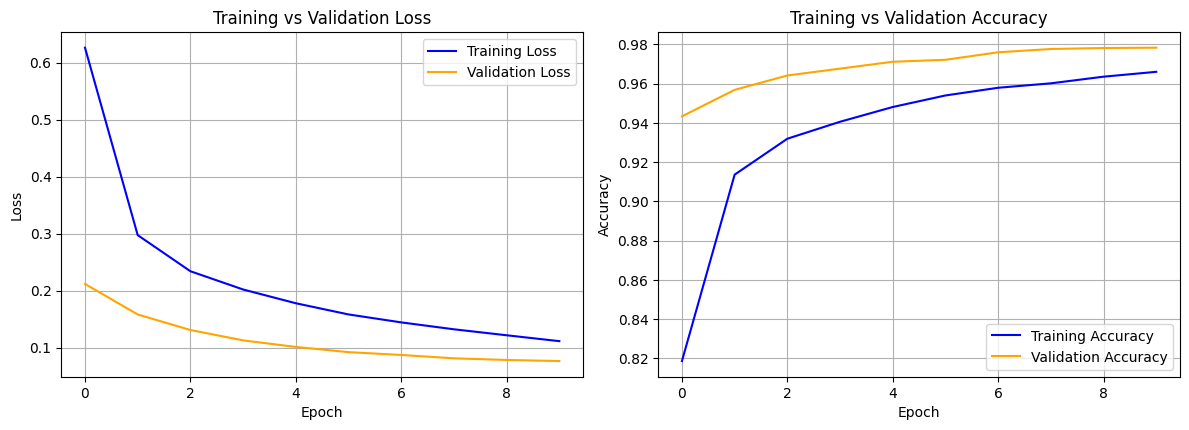

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
dnn_learning_rate = 0.0001
batch_size = 64
epochs = 10  # Increase the number of epochs for better convergence

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the DNN model
def create_dnn_model(learning_rate):
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.09),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the DNN model and record history
dnn_model = create_dnn_model(dnn_learning_rate)
history = dnn_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
dnn_test_loss, dnn_test_acc = dnn_model.evaluate(test_images_rgb, test_labels)
print(f"DNN Test accuracy (LR={dnn_learning_rate}): {dnn_test_acc}")

# Predict probabilities for the test dataset
test_pred_probs = dnn_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"DNN Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/10
844/844 [==============================] - 9s 9ms/step - loss: 0.3138 - accuracy: 0.9040 - val_loss: 0.1288 - val_accuracy: 0.9615
Epoch 2/10
844/844 [==============================] - 7s 8ms/step - loss: 0.1699 - accuracy: 0.9485 - val_loss: 0.0914 - val_accuracy: 0.9727
Epoch 3/10
844/844 [==============================] - 6s 8ms/step - loss: 0.1360 - accuracy: 0.9574 - val_loss: 0.0842 - val_accuracy: 0.9733
Epoch 4/10
844/844 [==============================] - 7s 8ms/step - loss: 0.1199 - accuracy: 0.9616 - val_loss: 0.0768 - val_accuracy: 0.9780
Epoch 5/10
844/844 [==============================] - 7s 9ms/step - loss: 0.1060 - accuracy: 0.9669 - val_loss: 0.0740 - val_accuracy: 0.9778
Epoch 6/10
844/844 [==============================] - 7s 9ms/step - loss: 0.0956 - accuracy: 0.9702 - val_loss: 0.0734 - val_accuracy: 0.9798
Epoch 7/10
844/844 [==============================] - 8s 10ms/step - loss: 0.0886 - accuracy: 0.9723 - val_loss: 0.0690 - val_accuracy: 0.9800
Epoch

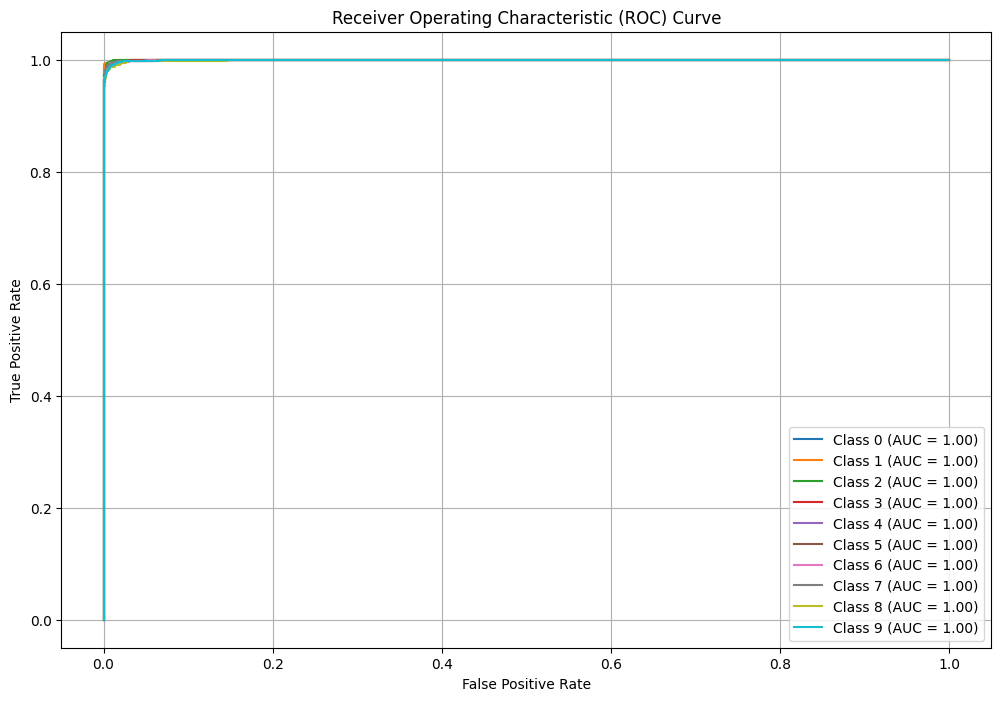

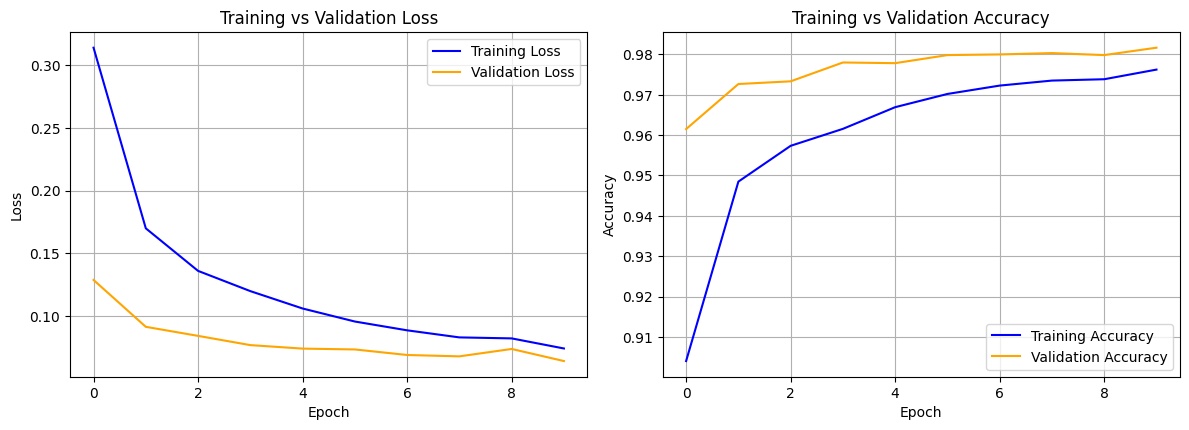

In [9]:
# Define the learning rate and other hyperparameters
dnn_learning_rate = 0.001
batch_size = 64
epochs = 10  # Increase the number of epochs for better convergence

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the DNN model
def create_dnn_model(learning_rate):
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.09),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the DNN model and record history
dnn_model = create_dnn_model(dnn_learning_rate)
history = dnn_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
dnn_test_loss, dnn_test_acc = dnn_model.evaluate(test_images_rgb, test_labels)
print(f"DNN Test accuracy (LR={dnn_learning_rate}): {dnn_test_acc}")

# Predict probabilities for the test dataset
test_pred_probs = dnn_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"DNN Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/20
844/844 [==============================] - 8s 8ms/step - loss: 0.4535 - accuracy: 0.8650 - val_loss: 0.2071 - val_accuracy: 0.9400
Epoch 2/20
844/844 [==============================] - 7s 9ms/step - loss: 0.3405 - accuracy: 0.9027 - val_loss: 0.1708 - val_accuracy: 0.9555
Epoch 3/20
844/844 [==============================] - 7s 9ms/step - loss: 0.3195 - accuracy: 0.9125 - val_loss: 0.1856 - val_accuracy: 0.9535
Epoch 4/20
844/844 [==============================] - 7s 9ms/step - loss: 0.3158 - accuracy: 0.9133 - val_loss: 0.1688 - val_accuracy: 0.9523
Epoch 5/20
844/844 [==============================] - 7s 9ms/step - loss: 0.3016 - accuracy: 0.9184 - val_loss: 0.1869 - val_accuracy: 0.9492
Epoch 6/20
844/844 [==============================] - 7s 8ms/step - loss: 0.2932 - accuracy: 0.9217 - val_loss: 0.1665 - val_accuracy: 0.9590
Epoch 7/20
844/844 [==============================] - 7s 8ms/step - loss: 0.2859 - accuracy: 0.9224 - val_loss: 0.1931 - val_accuracy: 0.9463
Epoch 

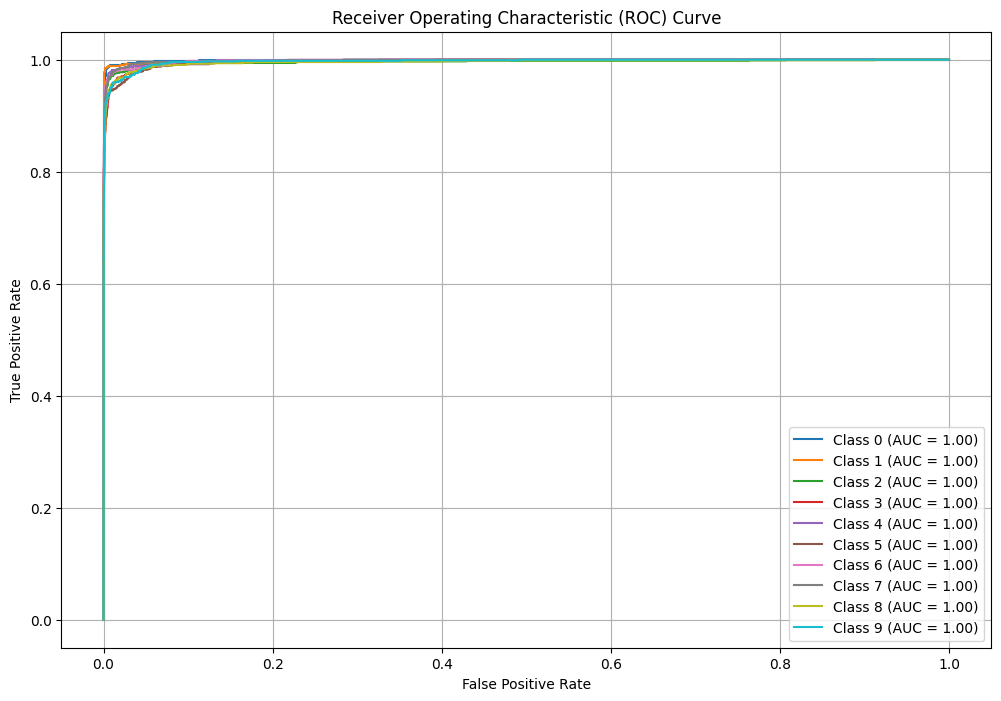

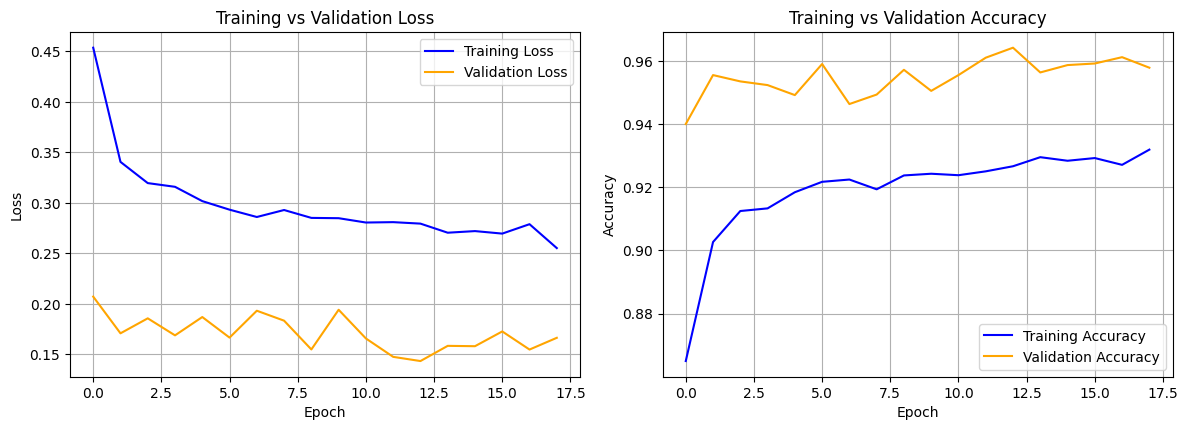

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
dnn_learning_rate = 0.01
batch_size = 64
epochs = 20  

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the DNN model
def create_dnn_model(learning_rate):
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.09),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the DNN model and record history
dnn_model = create_dnn_model(dnn_learning_rate)
history = dnn_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
dnn_test_loss, dnn_test_acc = dnn_model.evaluate(test_images_rgb, test_labels)
print(f"DNN Test accuracy (LR={dnn_learning_rate}): {dnn_test_acc}")

# Predict probabilities for the test dataset
test_pred_probs = dnn_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"DNN Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/10
106/106 [==============================] - 2s 14ms/step - loss: 5.5623 - accuracy: 0.2745 - val_loss: 1.6399 - val_accuracy: 0.3787
Epoch 2/10
106/106 [==============================] - 1s 11ms/step - loss: 1.6691 - accuracy: 0.3657 - val_loss: 1.2095 - val_accuracy: 0.5393
Epoch 3/10
106/106 [==============================] - 1s 11ms/step - loss: 1.3289 - accuracy: 0.5097 - val_loss: 0.8593 - val_accuracy: 0.7230
Epoch 4/10
106/106 [==============================] - 1s 11ms/step - loss: 1.0953 - accuracy: 0.5937 - val_loss: 0.7420 - val_accuracy: 0.7100
Epoch 5/10
106/106 [==============================] - 1s 11ms/step - loss: 1.0236 - accuracy: 0.6204 - val_loss: 0.6917 - val_accuracy: 0.7347
Epoch 6/10
106/106 [==============================] - 1s 11ms/step - loss: 0.9991 - accuracy: 0.6331 - val_loss: 0.6768 - val_accuracy: 0.7312
Epoch 7/10
106/106 [==============================] - 1s 11ms/step - loss: 1.0169 - accuracy: 0.6222 - val_loss: 0.7467 - val_accuracy: 0.7422

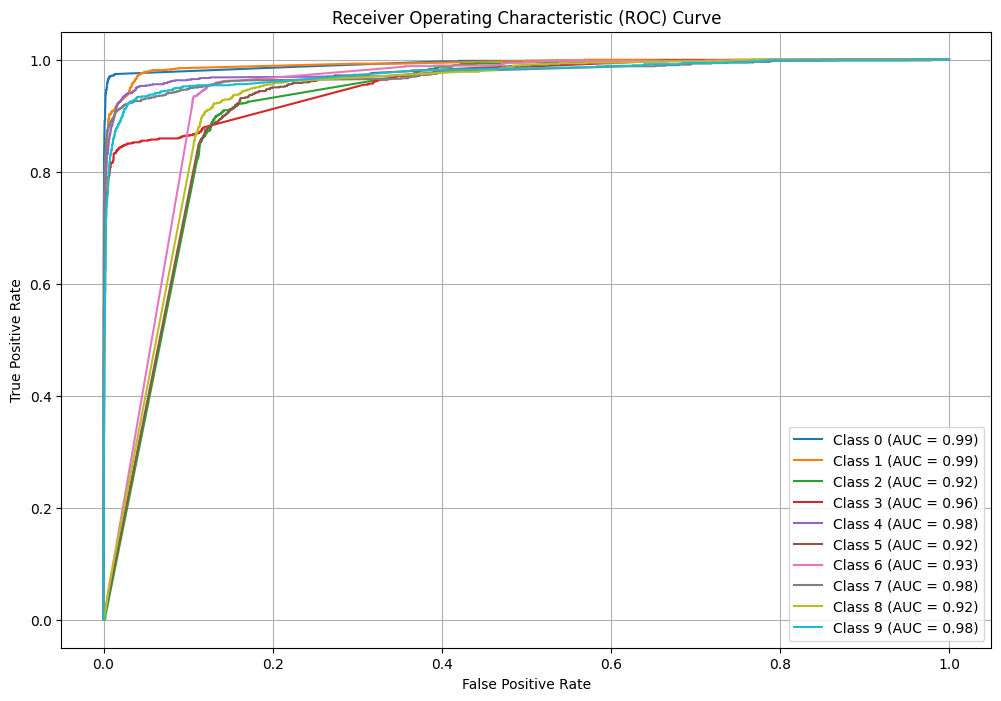

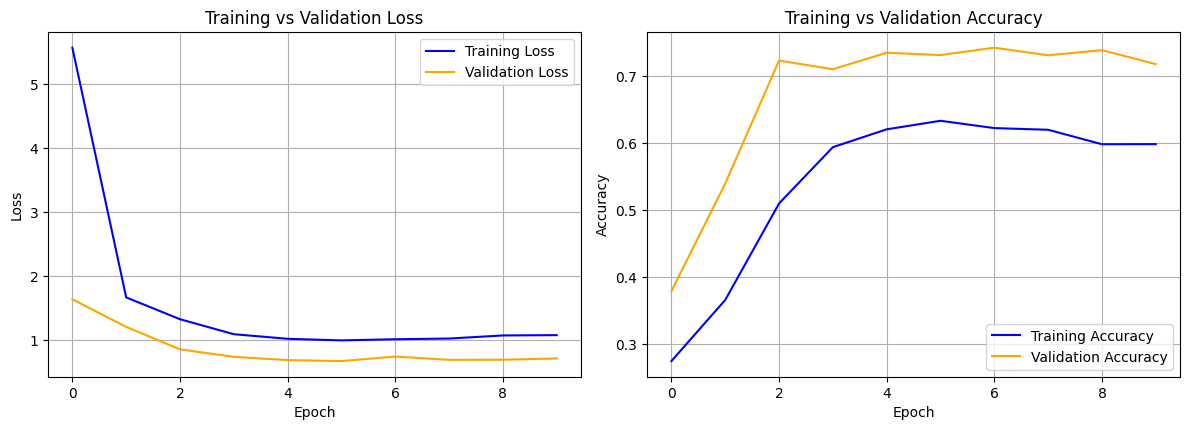

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
dnn_learning_rate = 0.1
batch_size = 512
epochs = 10

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the DNN model
def create_dnn_model(learning_rate):
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.09),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the DNN model and record history
dnn_model = create_dnn_model(dnn_learning_rate)
history = dnn_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
dnn_test_loss, dnn_test_acc = dnn_model.evaluate(test_images_rgb, test_labels)
print(f"DNN Test accuracy (LR={dnn_learning_rate}): {dnn_test_acc}")

# Predict probabilities for the test dataset
test_pred_probs = dnn_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"DNN Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/10
844/844 [==============================] - 57s 67ms/step - loss: 1.0859 - accuracy: 0.8872 - val_loss: 0.6941 - val_accuracy: 0.9763
Epoch 2/10
844/844 [==============================] - 58s 68ms/step - loss: 0.6666 - accuracy: 0.9683 - val_loss: 0.5737 - val_accuracy: 0.9825
Epoch 3/10
844/844 [==============================] - 56s 66ms/step - loss: 0.5517 - accuracy: 0.9769 - val_loss: 0.4850 - val_accuracy: 0.9852
Epoch 4/10
844/844 [==============================] - 57s 67ms/step - loss: 0.4610 - accuracy: 0.9819 - val_loss: 0.4089 - val_accuracy: 0.9880
Epoch 5/10
844/844 [==============================] - 57s 68ms/step - loss: 0.3864 - accuracy: 0.9833 - val_loss: 0.3415 - val_accuracy: 0.9893
Epoch 6/10
844/844 [==============================] - 57s 68ms/step - loss: 0.3223 - accuracy: 0.9856 - val_loss: 0.2960 - val_accuracy: 0.9872
Epoch 7/10
844/844 [==============================] - 57s 68ms/step - loss: 0.2709 - accuracy: 0.9865 - val_loss: 0.2405 - val_accuracy:

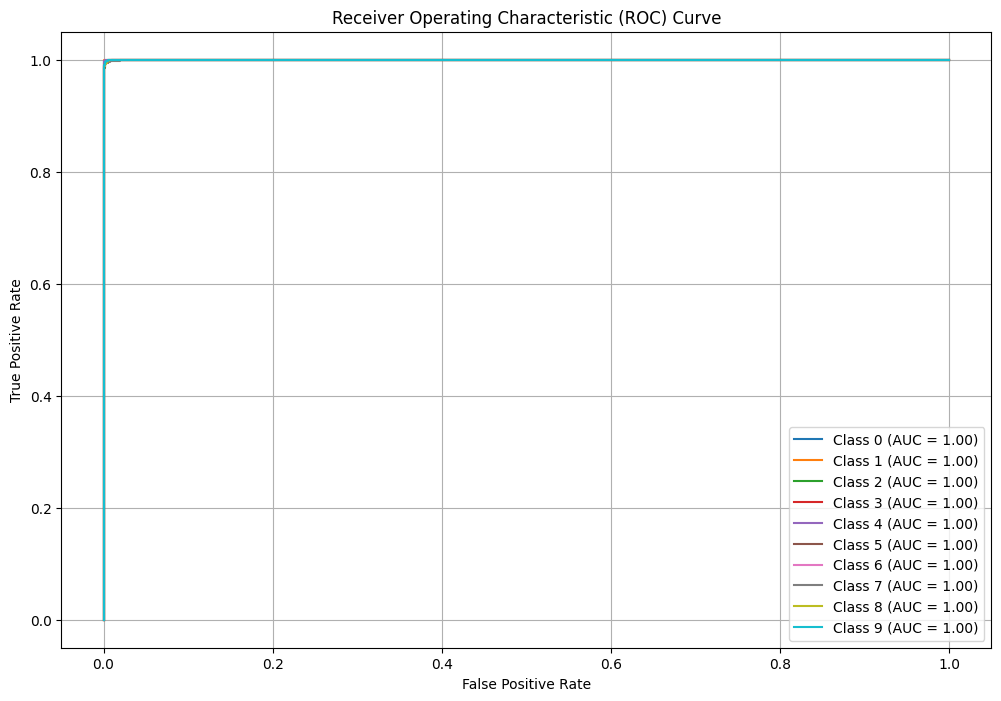

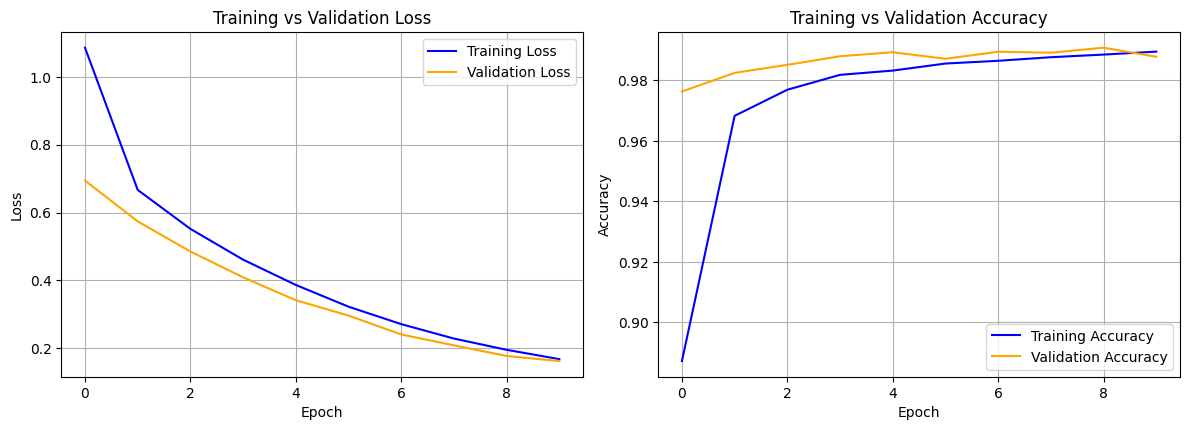

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
convnet_learning_rate = 0.0001
batch_size = 64
epochs = 10  # Increase the number of epochs for better convergence

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the ConvNet model
def create_convnet_model(learning_rate):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the ConvNet model and record history
convnet_model = create_convnet_model(convnet_learning_rate)
history = convnet_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
convnet_test_loss, convnet_test_acc = convnet_model.evaluate(test_images_rgb, test_labels)
print(f"ConvNet Test accuracy (LR={convnet_learning_rate}): {convnet_test_acc:.4f}")

# Predict probabilities for the test dataset
test_pred_probs = convnet_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"ConvNet Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/10
844/844 [==============================] - 57s 66ms/step - loss: 0.4785 - accuracy: 0.9462 - val_loss: 0.2116 - val_accuracy: 0.9858
Epoch 2/10
844/844 [==============================] - 56s 67ms/step - loss: 0.2045 - accuracy: 0.9776 - val_loss: 0.1625 - val_accuracy: 0.9858
Epoch 3/10
844/844 [==============================] - 56s 66ms/step - loss: 0.1678 - accuracy: 0.9800 - val_loss: 0.1475 - val_accuracy: 0.9862
Epoch 4/10
844/844 [==============================] - 56s 67ms/step - loss: 0.1514 - accuracy: 0.9824 - val_loss: 0.1276 - val_accuracy: 0.9882
Epoch 5/10
844/844 [==============================] - 57s 68ms/step - loss: 0.1381 - accuracy: 0.9836 - val_loss: 0.1300 - val_accuracy: 0.9852
Epoch 6/10
844/844 [==============================] - 58s 69ms/step - loss: 0.1303 - accuracy: 0.9846 - val_loss: 0.1203 - val_accuracy: 0.9878
Epoch 7/10
844/844 [==============================] - 57s 68ms/step - loss: 0.1259 - accuracy: 0.9846 - val_loss: 0.1269 - val_accuracy:

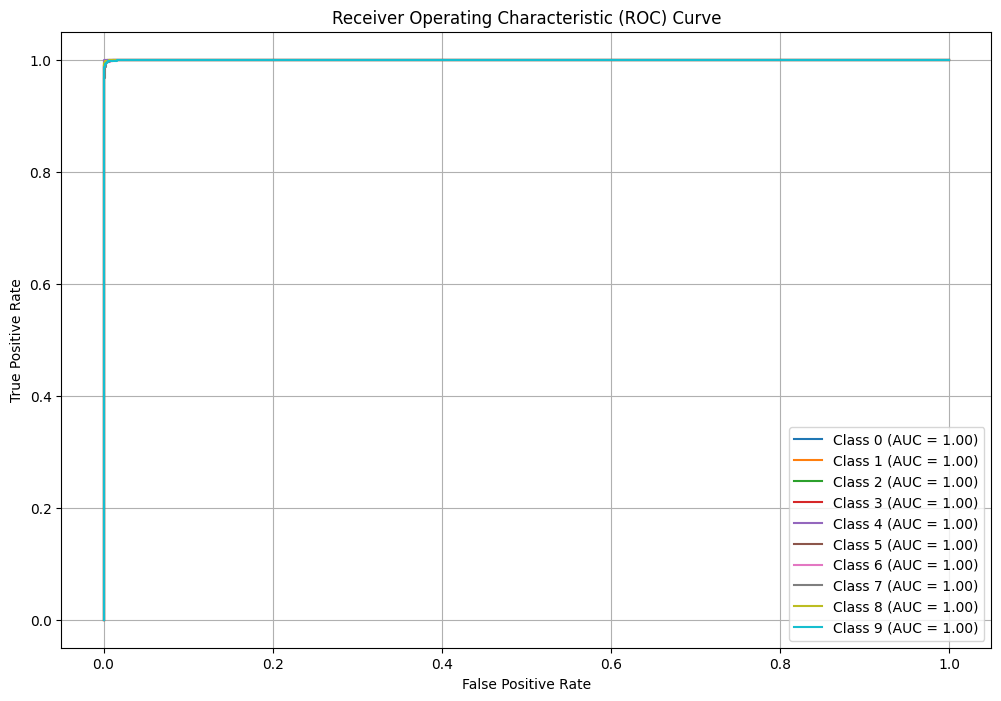

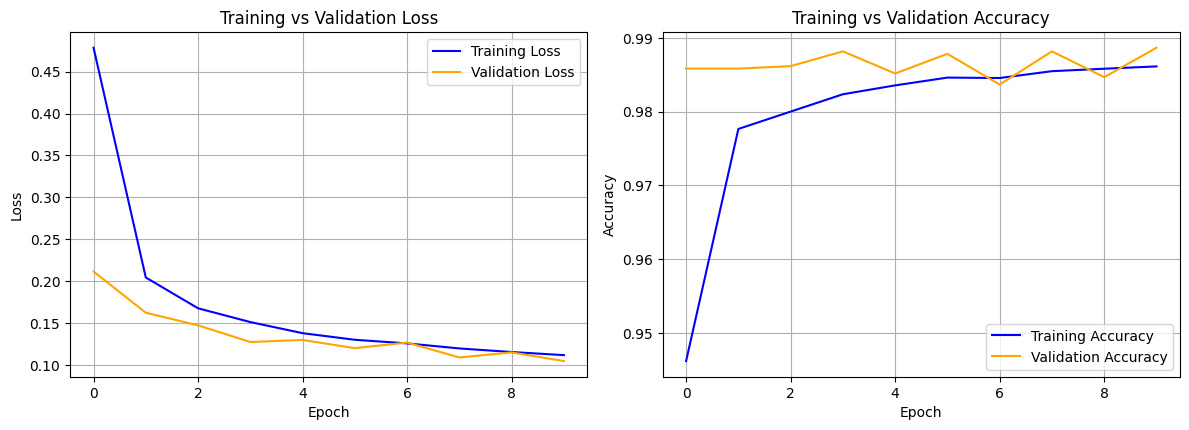

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
convnet_learning_rate = 0.001
batch_size = 64
epochs = 10  # Increase the number of epochs for better convergence

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the ConvNet model
def create_convnet_model(learning_rate):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the ConvNet model and record history
convnet_model = create_convnet_model(convnet_learning_rate)
history = convnet_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
convnet_test_loss, convnet_test_acc = convnet_model.evaluate(test_images_rgb, test_labels)
print(f"ConvNet Test accuracy (LR={convnet_learning_rate}): {convnet_test_acc:.4f}")

# Predict probabilities for the test dataset
test_pred_probs = convnet_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"ConvNet Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Epoch 1/10
844/844 [==============================] - 59s 69ms/step - loss: 0.5826 - accuracy: 0.8813 - val_loss: 0.2382 - val_accuracy: 0.9675
Epoch 2/10
844/844 [==============================] - 56s 67ms/step - loss: 0.3114 - accuracy: 0.9460 - val_loss: 0.2389 - val_accuracy: 0.9672
Epoch 3/10
844/844 [==============================] - 56s 66ms/step - loss: 0.3036 - accuracy: 0.9490 - val_loss: 0.2139 - val_accuracy: 0.9762
Epoch 4/10
844/844 [==============================] - 55s 65ms/step - loss: 0.3020 - accuracy: 0.9506 - val_loss: 0.2101 - val_accuracy: 0.9743
Epoch 5/10
844/844 [==============================] - 56s 66ms/step - loss: 0.3016 - accuracy: 0.9506 - val_loss: 0.2287 - val_accuracy: 0.9737
Epoch 6/10
844/844 [==============================] - 56s 66ms/step - loss: 0.2986 - accuracy: 0.9511 - val_loss: 0.2328 - val_accuracy: 0.9700
Epoch 7/10
844/844 [==============================] - 59s 70ms/step - loss: 0.3002 - accuracy: 0.9515 - val_loss: 0.2406 - val_accuracy:

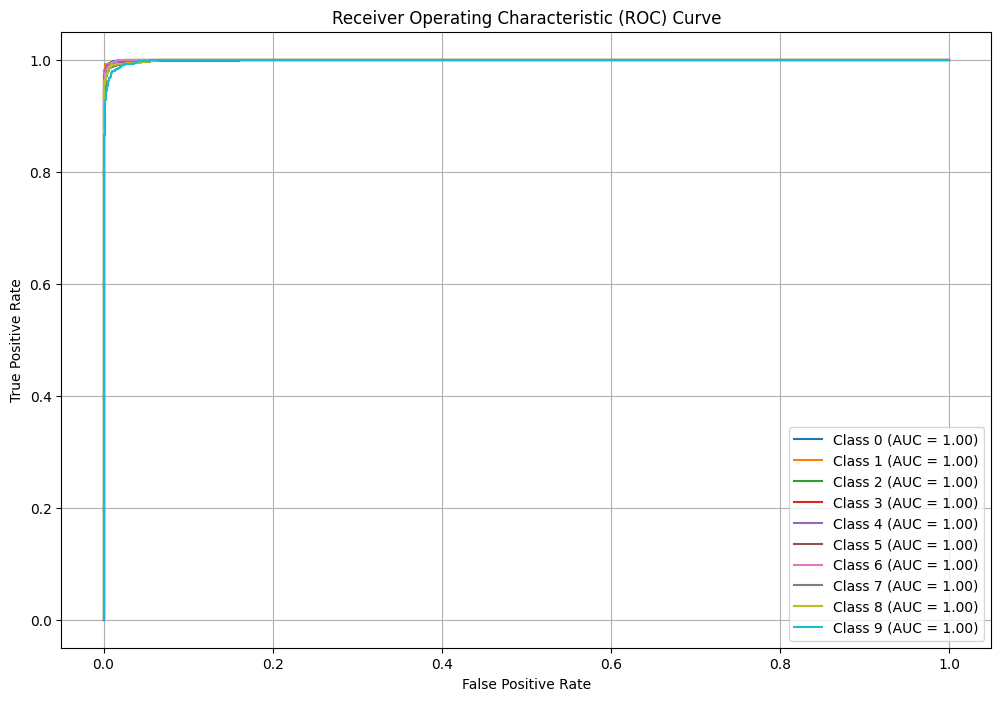

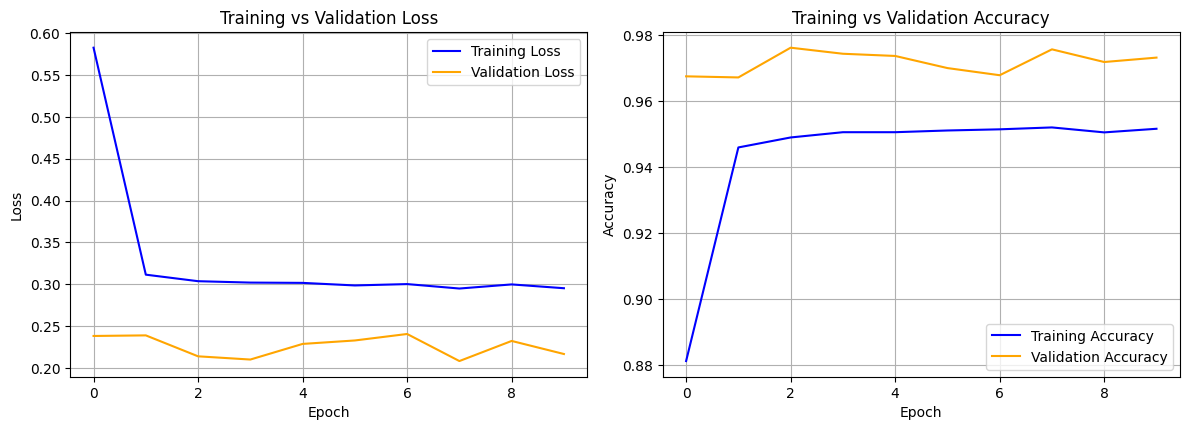

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
convnet_learning_rate = 0.01
batch_size = 64
epochs = 10  # Increase the number of epochs for better convergence

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the ConvNet model
def create_convnet_model(learning_rate):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the ConvNet model and record history
convnet_model = create_convnet_model(convnet_learning_rate)
history = convnet_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
convnet_test_loss, convnet_test_acc = convnet_model.evaluate(test_images_rgb, test_labels)
print(f"ConvNet Test accuracy (LR={convnet_learning_rate}): {convnet_test_acc:.4f}")

# Predict probabilities for the test dataset
test_pred_probs = convnet_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"ConvNet Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Epoch 1/10
211/211 [==============================] - 49s 226ms/step - loss: 510.4608 - accuracy: 0.1069 - val_loss: 70.6262 - val_accuracy: 0.1050
Epoch 2/10
211/211 [==============================] - 47s 221ms/step - loss: 63.9456 - accuracy: 0.1064 - val_loss: 58.2234 - val_accuracy: 0.1050
Epoch 3/10
211/211 [==============================] - 47s 224ms/step - loss: 53.7769 - accuracy: 0.1063 - val_loss: 49.6942 - val_accuracy: 0.0978
Epoch 4/10
211/211 [==============================] - 47s 222ms/step - loss: 46.2381 - accuracy: 0.1040 - val_loss: 42.9798 - val_accuracy: 0.1113
Epoch 5/10
211/211 [==============================] - 47s 223ms/step - loss: 40.1303 - accuracy: 0.1057 - val_loss: 37.4121 - val_accuracy: 0.1050
Epoch 6/10
211/211 [==============================] - 48s 229ms/step - loss: 34.9738 - accuracy: 0.1078 - val_loss: 32.6352 - val_accuracy: 0.0952
Epoch 7/10
211/211 [==============================] - 47s 223ms/step - loss: 30.5263 - accuracy: 0.1066 - val_loss: 2

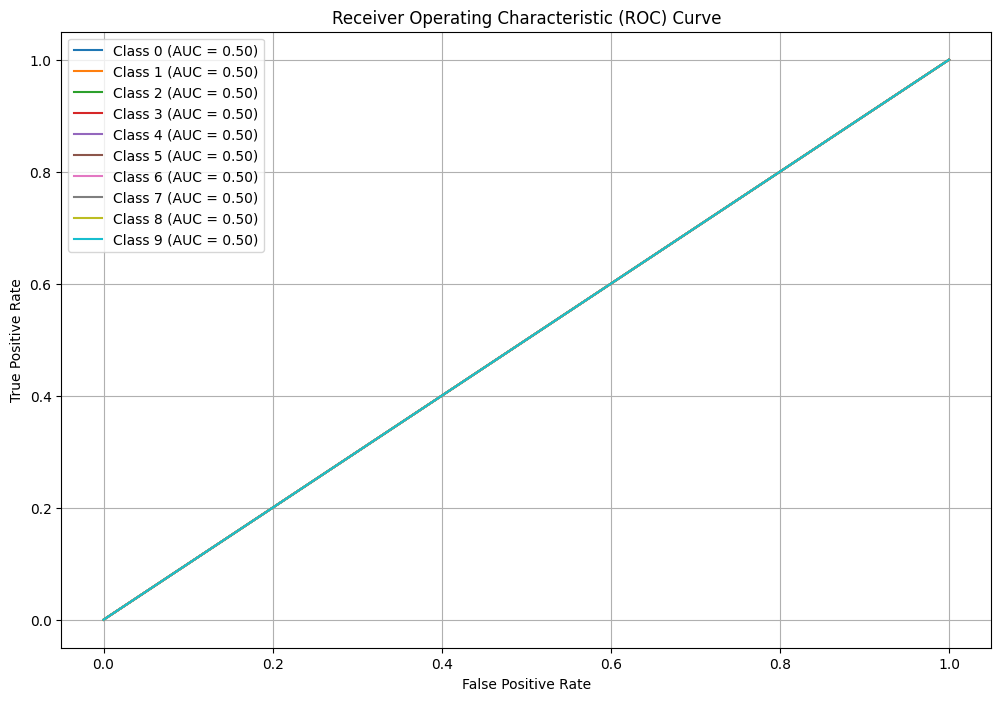

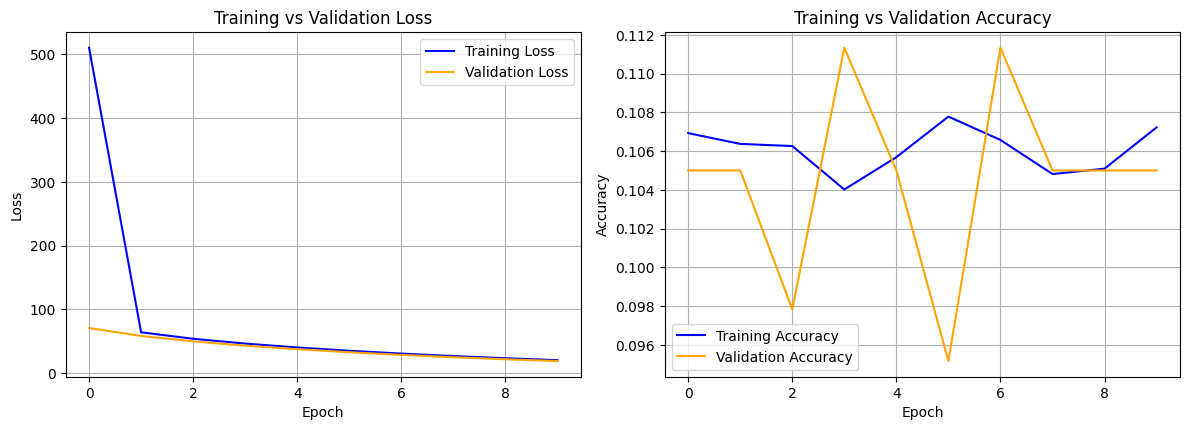

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc

# Define the learning rate and other hyperparameters
convnet_learning_rate = 0.1
batch_size = 256
epochs = 10  # Increase the number of epochs for better convergence

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the ConvNet model
def create_convnet_model(learning_rate):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the ConvNet model and record history
convnet_model = create_convnet_model(convnet_learning_rate)
history = convnet_model.fit(train_images_rgb, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
convnet_test_loss, convnet_test_acc = convnet_model.evaluate(test_images_rgb, test_labels)
print(f"ConvNet Test accuracy (LR={convnet_learning_rate}): {convnet_test_acc:.4f}")

# Predict probabilities for the test dataset
test_pred_probs = convnet_model.predict(test_images_rgb)

# Calculate F1 score
test_pred_labels = np.argmax(test_pred_probs, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
print(f"ConvNet Test F1 Score: {f1:.4f}")

# Plot ROC curve and AUC for each class
plt.figure(figsize=(12, 8))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)

# Loss plot, accuracy plot
plt.figure(figsize=(12, 8))

# Training vs validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Epoch 1/5
469/469 [==============================] - 1953s 4s/step - loss: 0.2825 - accuracy: 0.9163 - val_loss: 3.4664 - val_accuracy: 0.2161
Epoch 2/5
469/469 [==============================] - 2683s 6s/step - loss: 0.0447 - accuracy: 0.9871 - val_loss: 0.5805 - val_accuracy: 0.8094
Epoch 3/5
469/469 [==============================] - 1726s 4s/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.0600 - val_accuracy: 0.9813
Epoch 4/5
469/469 [==============================] - 1267s 3s/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 5/5
313/313 [==============================] - 21s 67ms/step - loss: 0.0251 - accuracy: 0.9928
Deeper ResNet-50 Test accuracy (LR=0.0001): 0.9928
313/313 [==============================] - 23s 67ms/step
Deeper ResNet-50 Test F1 Score: 0.9928
313/313 [==============================] - 21s 67ms/step


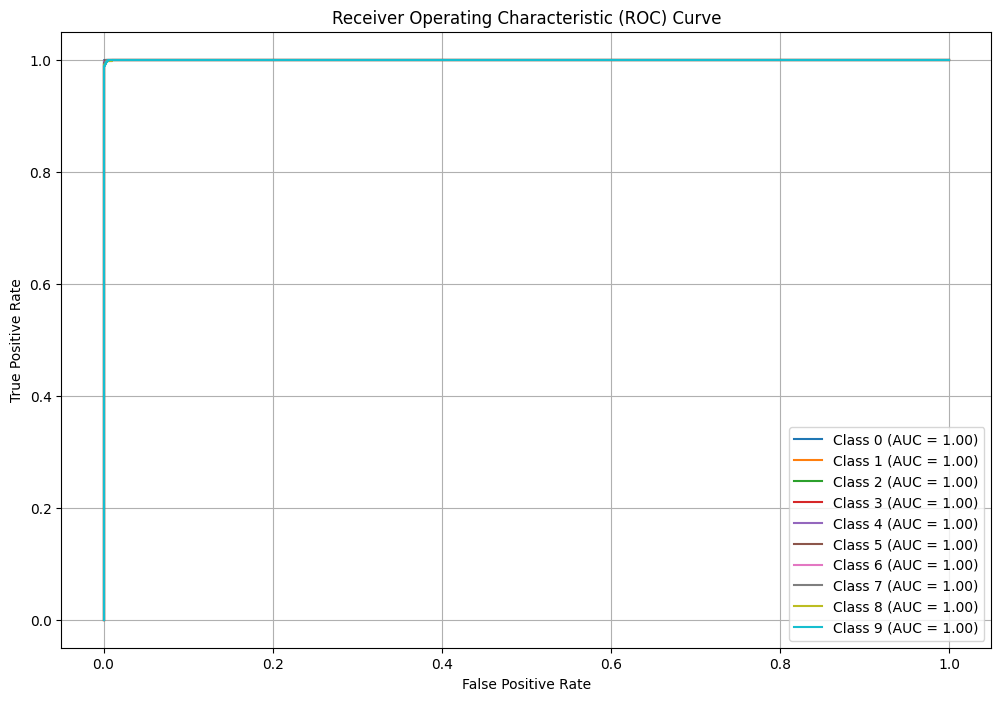

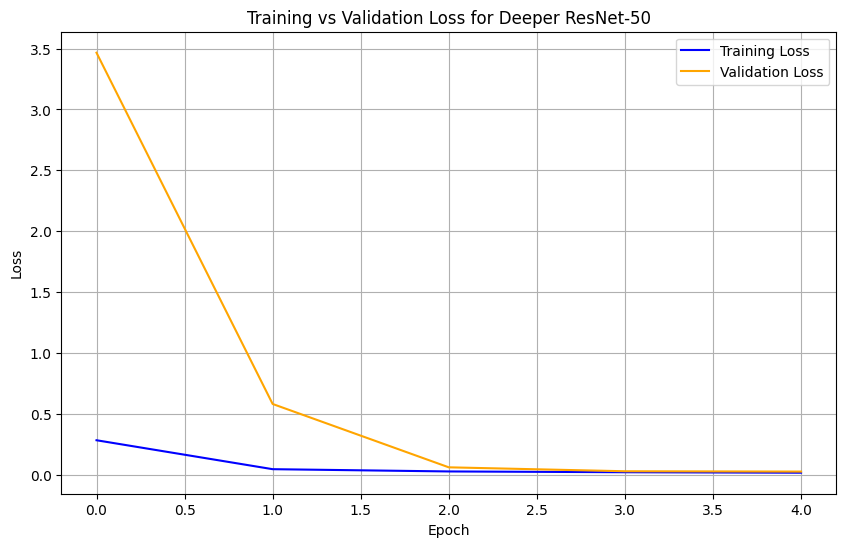

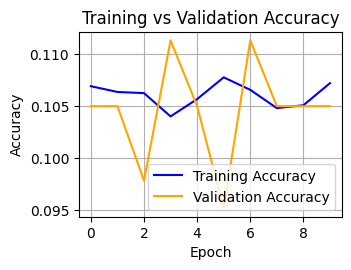

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score, roc_curve, auc
from tensorflow.keras.applications import ResNet50

# Function to calculate F1 score
def calculate_f1_score(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    test_pred_labels = np.argmax(test_pred_probs, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)
    f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
    return f1

# Function to plot ROC curve and AUC
def plot_roc_auc(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    
    plt.figure(figsize=(12, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create deeper ResNet-50-like model
def create_deeper_resnet50_model(learning_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the learning rate
resnet_learning_rate = 0.0001

# Create and compile the deeper ResNet-50-based model
deeper_resnet50_model = create_deeper_resnet50_model(resnet_learning_rate)

# Training 
history_deeper_resnet50 = deeper_resnet50_model.fit(
    train_images_rgb, train_labels,
    epochs=5,  # Increase the number of epochs
    batch_size=128,
    validation_data=(test_images_rgb, test_labels),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# Evaluate and print test accuracy
deeper_resnet50_test_loss, deeper_resnet50_test_acc = deeper_resnet50_model.evaluate(test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test accuracy (LR={resnet_learning_rate}): {deeper_resnet50_test_acc:.4f}")

# Calculate and print F1 score
deeper_resnet50_test_f1 = calculate_f1_score(deeper_resnet50_model, test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test F1 Score: {deeper_resnet50_test_f1:.4f}")

# Plot ROC curve and AUC
plot_roc_auc(deeper_resnet50_model, test_images_rgb, test_labels)

# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_resnet50.history['loss'], label='Training Loss', color='blue')
plt.plot(history_deeper_resnet50.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for Deeper ResNet-50')
plt.legend()
plt.grid(True)
plt.show()



# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Epoch 1/5
235/235 [==============================] - 1461s 6s/step - loss: 0.1330 - accuracy: 0.9626 - val_loss: 3.3325 - val_accuracy: 0.1135
Epoch 2/5
235/235 [==============================] - 1181s 5s/step - loss: 0.0408 - accuracy: 0.9889 - val_loss: 2.4961 - val_accuracy: 0.1872
Epoch 3/5
235/235 [==============================] - 1297s 6s/step - loss: 0.0307 - accuracy: 0.9917 - val_loss: 0.3835 - val_accuracy: 0.8739
Epoch 4/5
235/235 [==============================] - 1224s 5s/step - loss: 0.0234 - accuracy: 0.9938 - val_loss: 0.1156 - val_accuracy: 0.9645
Epoch 5/5
313/313 [==============================] - 20s 64ms/step - loss: 0.0245 - accuracy: 0.9933
Deeper ResNet-50 Test accuracy (LR=0.001): 0.9933
313/313 [==============================] - 22s 66ms/step
Deeper ResNet-50 Test F1 Score: 0.9933
313/313 [==============================] - 21s 66ms/step


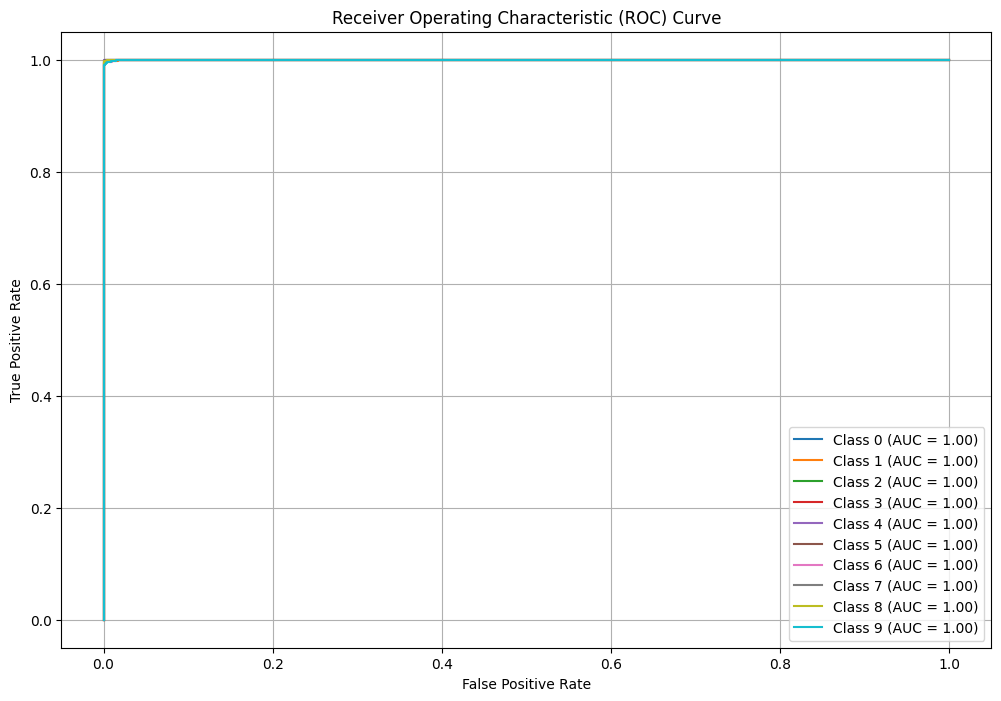

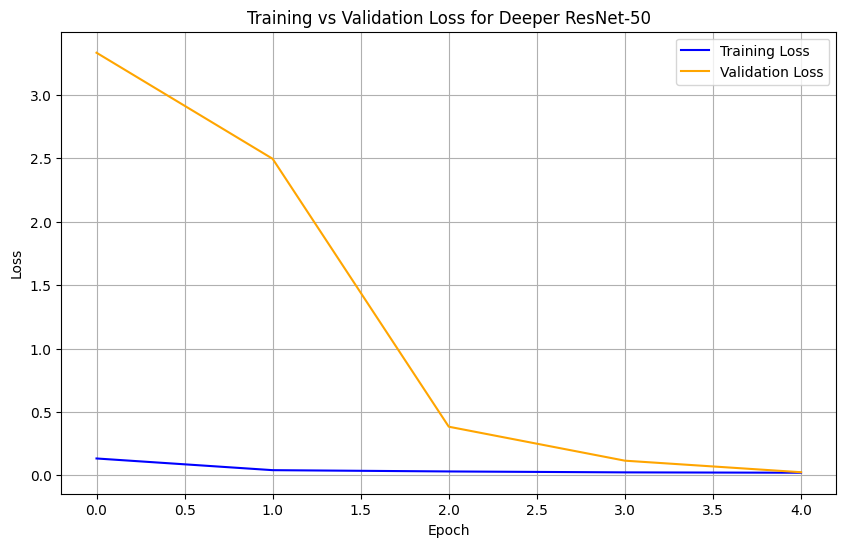

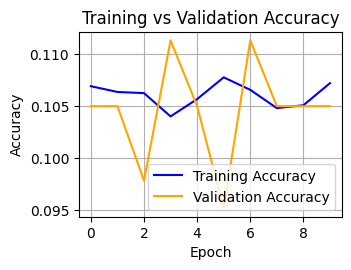

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score, roc_curve, auc
from tensorflow.keras.applications import ResNet50

# Function to calculate F1 score
def calculate_f1_score(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    test_pred_labels = np.argmax(test_pred_probs, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)
    f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
    return f1

# Function to plot ROC curve and AUC
def plot_roc_auc(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    
    plt.figure(figsize=(12, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create deeper ResNet-50-like model
def create_deeper_resnet50_model(learning_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the learning rate
resnet_learning_rate = 0.001

# Create and compile the deeper ResNet-50-based model
deeper_resnet50_model = create_deeper_resnet50_model(resnet_learning_rate)

# Training 
history_deeper_resnet50 = deeper_resnet50_model.fit(
    train_images_rgb, train_labels,
    epochs=5,  # Increase the number of epochs
    batch_size=256,
    validation_data=(test_images_rgb, test_labels),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# Evaluate and print test accuracy
deeper_resnet50_test_loss, deeper_resnet50_test_acc = deeper_resnet50_model.evaluate(test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test accuracy (LR={resnet_learning_rate}): {deeper_resnet50_test_acc:.4f}")

# Calculate and print F1 score
deeper_resnet50_test_f1 = calculate_f1_score(deeper_resnet50_model, test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test F1 Score: {deeper_resnet50_test_f1:.4f}")

# Plot ROC curve and AUC
plot_roc_auc(deeper_resnet50_model, test_images_rgb, test_labels)

# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_resnet50.history['loss'], label='Training Loss', color='blue')
plt.plot(history_deeper_resnet50.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for Deeper ResNet-50')
plt.legend()
plt.grid(True)
plt.show()



# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Epoch 1/5
118/118 [==============================] - 1650s 14s/step - loss: 0.5620 - accuracy: 0.8102 - val_loss: 4.7581 - val_accuracy: 0.1135
Epoch 2/5
118/118 [==============================] - 1440s 12s/step - loss: 0.0759 - accuracy: 0.9794 - val_loss: 11.7582 - val_accuracy: 0.1135
Epoch 3/5
118/118 [==============================] - 1153s 10s/step - loss: 0.0497 - accuracy: 0.9863 - val_loss: 4.0091 - val_accuracy: 0.2071
Epoch 4/5
118/118 [==============================] - 1133s 10s/step - loss: 0.0400 - accuracy: 0.9886 - val_loss: 4.4087 - val_accuracy: 0.2632
Epoch 5/5
313/313 [==============================] - 14s 43ms/step - loss: 2.5969 - accuracy: 0.4527
Deeper ResNet-50 Test accuracy (LR=0.01): 0.4527
313/313 [==============================] - 14s 43ms/step
Deeper ResNet-50 Test F1 Score: 0.3859
313/313 [==============================] - 13s 43ms/step


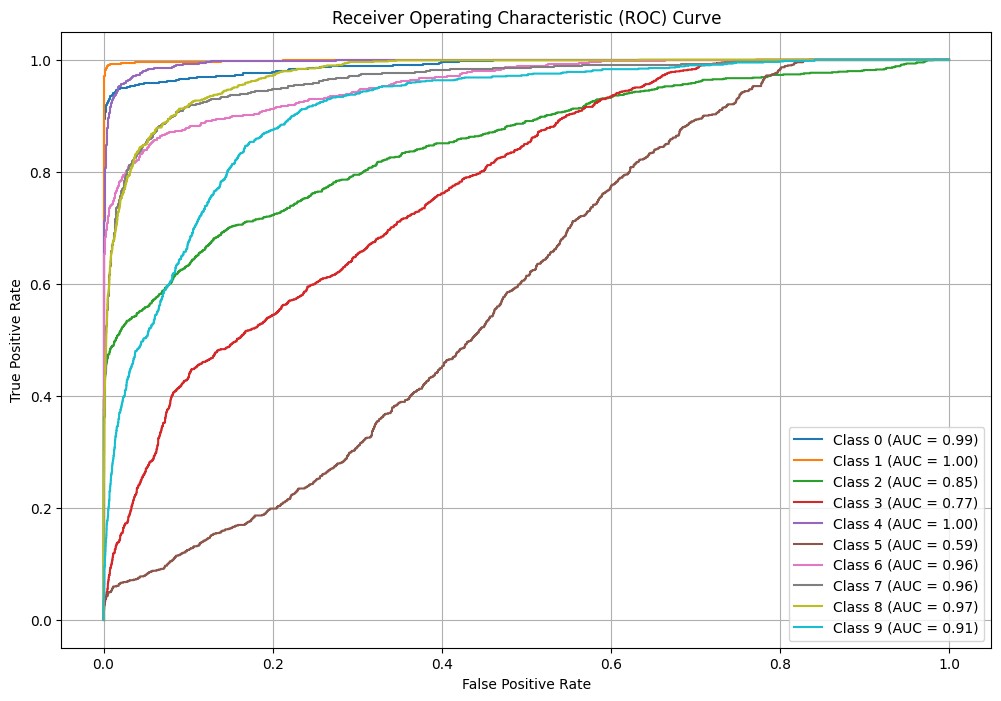

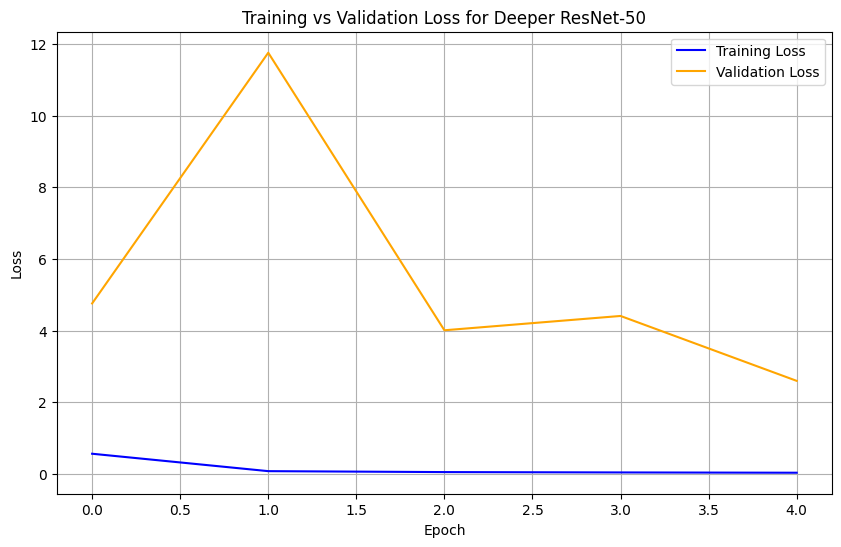

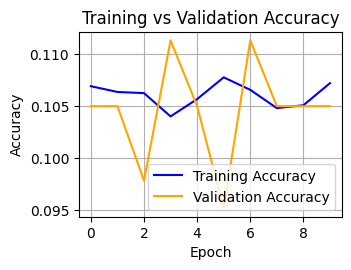

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score, roc_curve, auc
from tensorflow.keras.applications import ResNet50

# Function to calculate F1 score
def calculate_f1_score(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    test_pred_labels = np.argmax(test_pred_probs, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)
    f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
    return f1

# Function to plot ROC curve and AUC
def plot_roc_auc(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    
    plt.figure(figsize=(12, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create deeper ResNet-50-like model
def create_deeper_resnet50_model(learning_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the learning rate
resnet_learning_rate = 0.01

# Create and compile the deeper ResNet-50-based model
deeper_resnet50_model = create_deeper_resnet50_model(resnet_learning_rate)

# Training 
history_deeper_resnet50 = deeper_resnet50_model.fit(
    train_images_rgb, train_labels,
    epochs=5,  # Increase the number of epochs
    batch_size=512,
    validation_data=(test_images_rgb, test_labels),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# Evaluate and print test accuracy
deeper_resnet50_test_loss, deeper_resnet50_test_acc = deeper_resnet50_model.evaluate(test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test accuracy (LR={resnet_learning_rate}): {deeper_resnet50_test_acc:.4f}")

# Calculate and print F1 score
deeper_resnet50_test_f1 = calculate_f1_score(deeper_resnet50_model, test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test F1 Score: {deeper_resnet50_test_f1:.4f}")

# Plot ROC curve and AUC
plot_roc_auc(deeper_resnet50_model, test_images_rgb, test_labels)

# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_resnet50.history['loss'], label='Training Loss', color='blue')
plt.plot(history_deeper_resnet50.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for Deeper ResNet-50')
plt.legend()
plt.grid(True)
plt.show()



# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Epoch 1/5
118/118 [==============================] - 1208s 10s/step - loss: 1.2525 - accuracy: 0.5557 - val_loss: 10664.6924 - val_accuracy: 0.0958
Epoch 2/5
118/118 [==============================] - 1088s 9s/step - loss: 0.1340 - accuracy: 0.9633 - val_loss: 1.4698 - val_accuracy: 0.7078
Epoch 3/5
118/118 [==============================] - 1094s 9s/step - loss: 0.0724 - accuracy: 0.9800 - val_loss: 0.9352 - val_accuracy: 0.7895
Epoch 4/5
118/118 [==============================] - 1073s 9s/step - loss: 0.0573 - accuracy: 0.9839 - val_loss: 0.2333 - val_accuracy: 0.9372
Epoch 5/5
313/313 [==============================] - 20s 64ms/step - loss: 0.3413 - accuracy: 0.9159
Deeper ResNet-50 Test accuracy (LR=0.1): 0.9159
313/313 [==============================] - 22s 64ms/step
Deeper ResNet-50 Test F1 Score: 0.9152
313/313 [==============================] - 21s 66ms/step


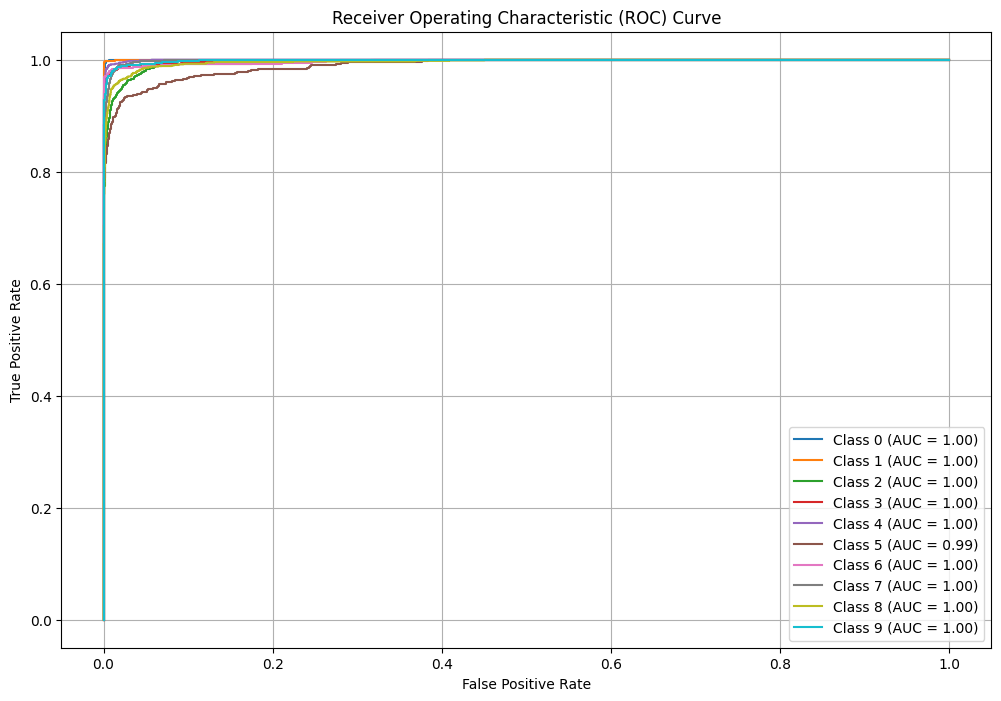

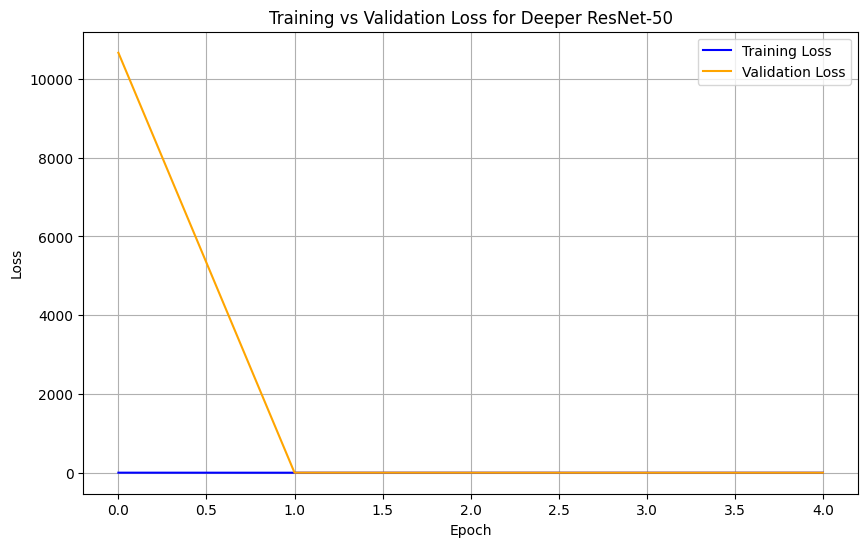

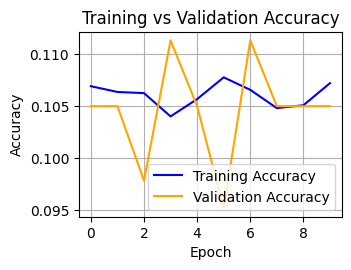

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score, roc_curve, auc
from tensorflow.keras.applications import ResNet50

# Function to calculate F1 score
def calculate_f1_score(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    test_pred_labels = np.argmax(test_pred_probs, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)
    f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
    return f1

# Function to plot ROC curve and AUC
def plot_roc_auc(model, test_data, test_labels):
    test_pred_probs = model.predict(test_data)
    
    plt.figure(figsize=(12, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create deeper ResNet-50-like model
def create_deeper_resnet50_model(learning_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the learning rate
resnet_learning_rate = 0.1

# Create and compile the deeper ResNet-50-based model
deeper_resnet50_model = create_deeper_resnet50_model(resnet_learning_rate)

# Training 
history_deeper_resnet50 = deeper_resnet50_model.fit(
    train_images_rgb, train_labels,
    epochs=5,  # Increase the number of epochs
    batch_size=512,
    validation_data=(test_images_rgb, test_labels),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# Evaluate and print test accuracy
deeper_resnet50_test_loss, deeper_resnet50_test_acc = deeper_resnet50_model.evaluate(test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test accuracy (LR={resnet_learning_rate}): {deeper_resnet50_test_acc:.4f}")

# Calculate and print F1 score
deeper_resnet50_test_f1 = calculate_f1_score(deeper_resnet50_model, test_images_rgb, test_labels)
print(f"Deeper ResNet-50 Test F1 Score: {deeper_resnet50_test_f1:.4f}")

# Plot ROC curve and AUC
plot_roc_auc(deeper_resnet50_model, test_images_rgb, test_labels)

# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_resnet50.history['loss'], label='Training Loss', color='blue')
plt.plot(history_deeper_resnet50.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for Deeper ResNet-50')
plt.legend()
plt.grid(True)
plt.show()



# Training vs validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()
